<div style="page-break-after: always;"></div>

![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/001.png?raw=1)![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/002.jpeg?raw=1)

**M2.875 Deep Learning**

Práctica                    Autor: Oscar Rojo Martín

# *Clasificador Neuronal para la detección de Glaucoma*

<div style="page-break-after: always;"></div>

1.  Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.


  
1. Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

- Diaz-Pinto, A., Morales, S., Naranjo, V. et al. *CNNs for automatic glaucoma assessment using fundus images: an extensive validation*. BioMed Eng OnLine 18, 29 (2019). <https://doi.org/10.1186/s12938-019-0649-y>

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha dividido en 10 particiones distintas que se usarán para aplicar un método de *cross validation* con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: *train*, *test* y *valid*. Las imágenes a su vez están etiquetadas de dos formas: *normal* o *abnormal*.


2. Función de evaluación

La función de evaluación que se utilizará a lo largo de la práctica será el **F1-score**.

6. Recursos

El conjunto de los datos del proyecto se puede encontrar en la dirección:

- <https://www.kaggle.com/datasets/jordidelatorreuoc/practica-dl-uoc-2022>



In [1]:
# Clono el repositorio de GitHub donde tengo guardado todos los archivos
# Esto último lo hago para ejecutar en google colab y no tener que hacerlo en
# un notebook... que no permite grandes cantidades procesos.
! git clone https://github.com/zumaiaUOC/DL_PRA.git
% cd /content/DL_PRA

Cloning into 'DL_PRA'...
remote: Enumerating objects: 1935, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1935 (delta 46), reused 113 (delta 45), pack-reused 1821
Receiving objects: 100% (1935/1935), 43.11 MiB | 35.86 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (17109/17109), done.
/content/DL_PRA


#### Importar librerias

In [2]:
# ultima version de tensorflow
#!pip install tf-nightly
# addons para utilizar F1 score
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [3]:
# Import libraries
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from sklearn.preprocessing import OneHotEncoder
import tensorflow_addons as tfa

import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer

tf.random.set_seed(42) # para reproducibilidad



In [4]:
# mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# go to the folder with the images
#% cd /content/drive/MyDrive/Colab Notebooks/DL-PRA

#### Cargar los datos desde kaggle usando API

In [6]:
# Import data from kaggle using Kaggle API
# ref.:https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953
# ! kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022


In [7]:
# unzip to data folder
# ! unzip -o practica-dl-uoc-2022.zip -d data/

In [8]:
# drop practica-dl-uoc-2022.zip
# ! rm practica-dl-uoc-2022.zip

In [9]:
# Load data
base_dir = 'data/practica_DL_UOC_2022/'

# list folder in data/practica-dl-uoc-2022/
subfolder = os.listdir(base_dir)
print(subfolder)


['Fold1', 'Fold4', 'Fold0', 'Fold3', 'Fold8', 'Fold2', 'Fold5', 'Fold7', 'Fold9', 'Fold6']


In [10]:
train_dir = os.path.join(base_dir, subfolder[0]+'/train/')
test_dir = os.path.join(base_dir, subfolder[0]+'/test/')
valid_dir = os.path.join(base_dir, subfolder[0]+'/valid/')

# directorio con imagenes normal de entrenamiento
train_normal_dir = os.path.join(train_dir, 'normal/')
# directorio con imagenes abnormal de entrenamiento
train_anormal_dir = os.path.join(train_dir, 'abnormal/')

# directorio con imagenes normal de test
test_normal_dir = os.path.join(test_dir, 'normal/')
# directorio con imagenes abnormal de test
test_anormal_dir = os.path.join(test_dir, 'abnormal/')

# directorio con imagenes normal de validacion
valid_normal_dir = os.path.join(valid_dir, 'normal/')
# directorio con imagenes abnormal de validacion
valid_anormal_dir = os.path.join(valid_dir, 'abnormal/')


In [11]:
train_anormal_dir_list = os.listdir(train_anormal_dir)
print(train_anormal_dir_list[0])

oSxoEaSoHR.jpg


#### Crear dataframe

In [12]:
df_all = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
train_test_valid = ['train', 'test', 'valid']
for i in subfolder:
    for h in train_test_valid:
        for j in norm_abnorm:
            x_dir = os.path.join(base_dir, i+'/'+h+'/'+j+'/')
            x_dir_list = os.listdir(x_dir)
            # create a dataframe with fold, set, status, image and full_path
            df = pd.DataFrame(x_dir_list, columns=['image'])
            df['fold'] = i
            df['set'] = h
            df['status'] = j
            df['full_path'] = df['image'].apply(lambda x: os.path.join(x_dir, x))
            df_all = pd.concat([df_all, df])

df_all 

,image,fold,set,status,full_path
0,WeyEZHlbVV.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/W...
1,GEdLbllOrL.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/G...
2,hxolFIPeVb.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/h...
3,embyZorZmz.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/e...
4,bDPsGesQtp.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/b...
...,...,...,...,...,...
65,ErXihucXJQ.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
66,dPNTYocBLU.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
67,gwnLFsoNDm.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
68,SUGFWkeBAl.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...


In [13]:
# Comprobar que el numero de imagenes es correcto



# **Sección 1. Análisis Exploratorio de los datos (1,5 puntos)**

Realizar un análisis exploratorio de los datos proporcionados, tanto en formato numérico como gráfico, donde se recoja la información relevante del conjunto de datos proporcionado.


In [14]:
df_all_train = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        train_dir = os.path.join(base_dir, i+'/train/')
        train_dir_dir = os.path.join(train_dir, j+'/')
        train_dir_list = os.listdir(train_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_train = pd.DataFrame({'fold': [i]*len(train_dir_list),
                                    'set': [j]*len(train_dir_list),
                                    'status': [j]*len(train_dir_list),
                                    'image': train_dir_list,
                                    'full_path': [os.path.join(train_dir_dir, x) for x in train_dir_list]})
        df_all_train = pd.concat([df_all_train, df_train])

print ("Numero de imagenes en train: ", len(df_all_train))
print("Dimension de train: ", df_all_train.shape)
    

Numero de imagenes en train:  13790
Dimension de train:  (13790, 5)


In [15]:
df_all_test = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        test_dir = os.path.join(base_dir, i+'/test/')
        test_dir_dir = os.path.join(test_dir, j+'/')
        test_dir_list = os.listdir(test_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_test = pd.DataFrame({'fold': [i]*len(test_dir_list),
                                'set': [j]*len(test_dir_list),
                                'status': [j]*len(test_dir_list),
                                'image': test_dir_list,
                                'full_path': [os.path.join(test_dir_dir, x) for x in test_dir_list]})
        df_all_test = pd.concat([df_all_test, df_test])

print("Numero de imagenes en test: ", len(df_all_test))
print("Dimension de test: ", df_all_test.shape)



Numero de imagenes en test:  1740
Dimension de test:  (1740, 5)


In [16]:
df_all_valid = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        valid_dir = os.path.join(base_dir, i+'/valid/')
        valid_dir_dir = os.path.join(valid_dir, j+'/')
        valid_dir_list = os.listdir(valid_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_valid = pd.DataFrame({'fold': [i]*len(valid_dir_list),
                                 'set': [j]*len(valid_dir_list),
                                 'status': [j]*len(valid_dir_list),
                                 'image': valid_dir_list,
                                 'full_path': [os.path.join(valid_dir_dir, x) for x in valid_dir_list]})
        df_all_valid = pd.concat([df_all_valid, df_valid])

print("Numero de imagenes en valid: ", len(df_all_valid))
print("Dimension de valid: ", df_all_valid.shape)


Numero de imagenes en valid:  1540
Dimension de valid:  (1540, 5)


In [17]:
# Numero de imagles normal para train, test y valid
df_all_test_normal = df_all_test[df_all_test['status'] == 'normal']
print("Numero de imagenes normal en test: ", len(df_all_test_normal))
print("Numero de imagenes abnorma en test: ", len(df_all_test) - len(df_all_test_normal))
# para train
df_all_train_normal = df_all_train[df_all_train['status'] == 'normal']
print("Numero de imagenes normal en train: ", len(df_all_train_normal))
print("Numero de imagenes abnorma en train: ", len(df_all_train) - len(df_all_train_normal))
# para valid
df_all_valid_normal = df_all_valid[df_all_valid['status'] == 'normal']
print("Numero de imagenes normal en valid: ", len(df_all_valid_normal))
print("Numero de imagenes abnorma en valid: ", len(df_all_valid) - len(df_all_valid_normal))



Numero de imagenes normal en test:  919
Numero de imagenes abnorma en test:  821
Numero de imagenes normal en train:  7452
Numero de imagenes abnorma en train:  6338
Numero de imagenes normal en valid:  819
Numero de imagenes abnorma en valid:  721


Dimensión: (17070, 5)


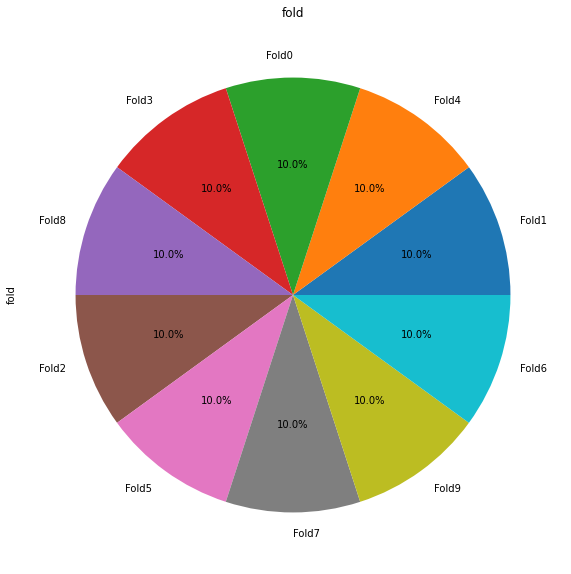

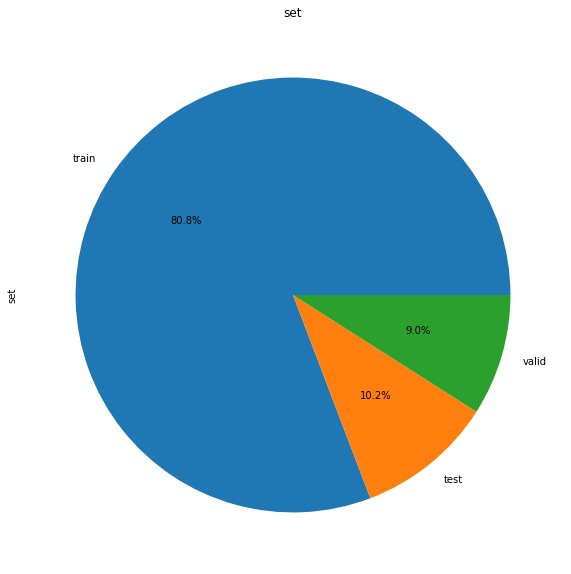

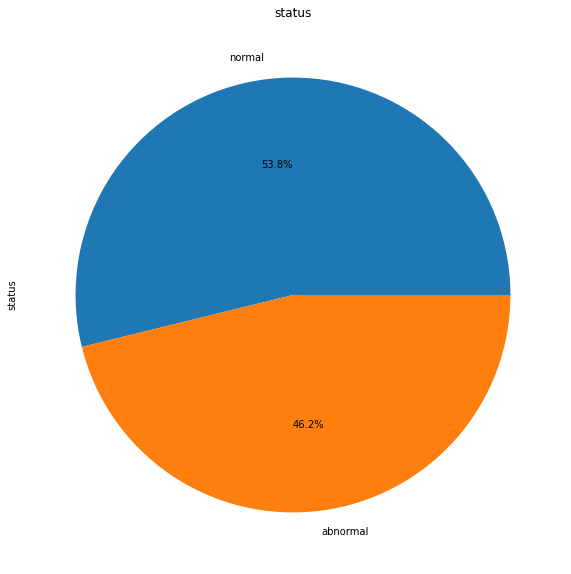

In [18]:
# Dimensión
print("Dimensión: {}".format(df_all.shape))

# list of columns
column_list = ['fold', 'set', 'status']   



# pie chart 
for i in column_list:
    df_all[i].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
    plt.title(i)
    plt.show()




In [19]:
# load images
def load_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = np.array(image)
    return image

load_image(df_all.iloc[0]['full_path'])


array([[[194,  86,  13],
        [195,  87,  14],
        [194,  88,  14],
        ...,
        [192,  90,  16],
        [191,  89,  15],
        [191,  89,  15]],

       [[194,  86,  13],
        [194,  88,  14],
        [195,  89,  15],
        ...,
        [188,  87,  15],
        [188,  87,  15],
        [188,  86,  14]],

       [[196,  88,  15],
        [196,  90,  16],
        [197,  91,  17],
        ...,
        [187,  86,  18],
        [187,  86,  18],
        [187,  86,  18]],

       ...,

       [[209,  93,  16],
        [210,  93,  16],
        [212,  92,  16],
        ...,
        [222, 106,  29],
        [222, 106,  29],
        [221, 105,  28]],

       [[209,  93,  16],
        [209,  92,  15],
        [212,  90,  15],
        ...,
        [222, 106,  29],
        [222, 106,  29],
        [222, 106,  29]],

       [[210,  94,  17],
        [210,  93,  16],
        [212,  90,  15],
        ...,
        [221, 105,  28],
        [222, 106,  29],
        [223, 107,  30]]

In [20]:
df_all_normal = df_all[df_all['status'] == 'normal']
df_all_abnormal = df_all[df_all['status'] == 'abnormal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Normal
JPEG
RGB
(224, 224)
Mean: 114.685
Min: 7.000, Max: 255.000
Mean: 0.000
Min: -107.685, Max: 140.315
Data Type: float64
Min: -107.685, Max: 140.315
pixel mean =  -4.2828168e-09
Min: -0.422, Max: 0.550


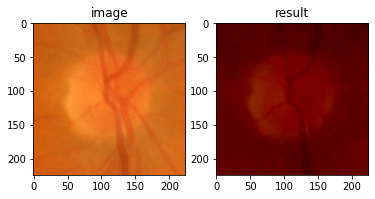

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Abnormal
JPEG
RGB
(224, 224)
Mean: 45.953
Min: 0.000, Max: 207.000
Mean: 0.000
Min: -45.953, Max: 161.047
Data Type: float64
Min: -45.953, Max: 161.047
pixel mean =  5.980738e-09
Min: -0.180, Max: 0.632


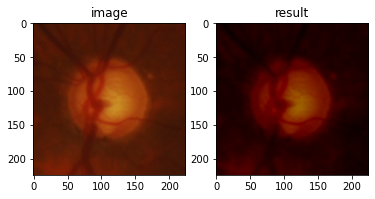

In [21]:
def image_info(path):
    image = Image.open(path)
    print(image.format)
    print(image.mode)
    print(image.size)
    pixels = asarray(image)
    # global centering


    # calculate global mean
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # global centering of pixels
    pixels = pixels - mean
    # confirm it had the desired effect
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    #print(pixels)


    # example of pixel normalization
    # confirm pixel range is 0-255
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    mean = pixels.mean()
    print('pixel mean = ', mean)

    # confirm the normalization
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # show the image
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('image')
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result')
    plt.show()
    
print('Imagen Normal')
image_info(df_all_normal.iloc[0]['full_path'])
print('Imagen Abnormal')
image_info(df_all_abnormal.iloc[0]['full_path'])


In [22]:
def imagen(path):
    image = Image.open(path)
    pixels = asarray(image) # convert image to numpy array
    # calculate global mean
    mean = pixels.mean()
    # global centering of pixels
    pixels = pixels - mean
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 14))
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('original image', fontsize=20)
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result', fontsize=20)
    plt.show()

# imagen(df_all.iloc[0]['full_path'])

##### ojo sano:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


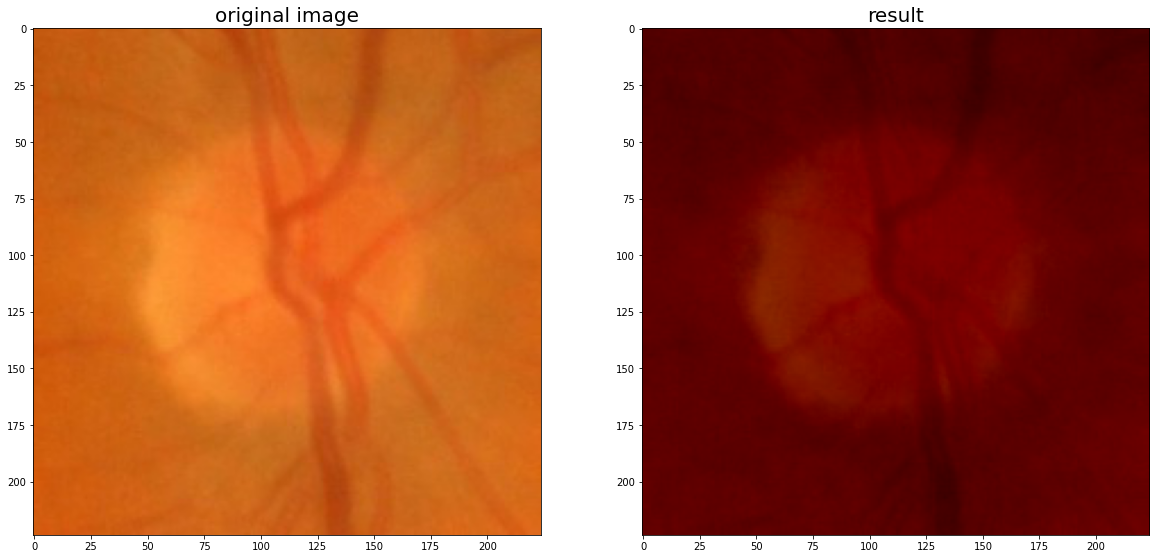

In [23]:
# filter df_all status = normal
df_all_normal = df_all[df_all['status'] == 'normal']
imagen(df_all_normal.iloc[0]['full_path'])

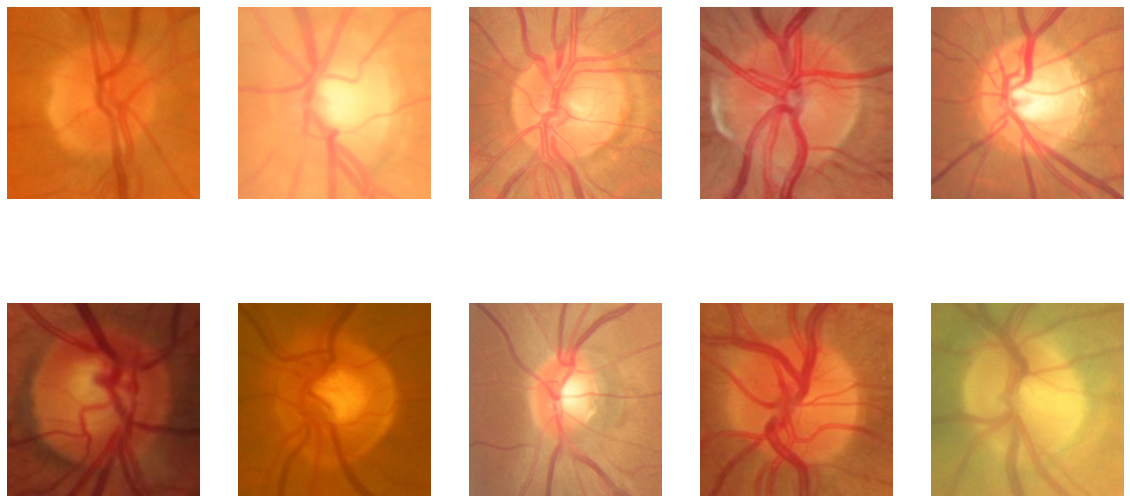

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i in range(10):
    axes[i//5, i%5].imshow(load_image(df_all_normal.iloc[i]['full_path']))
    axes[i//5, i%5].axis('off')
plt.show()

##### ojo con Glaucoma:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


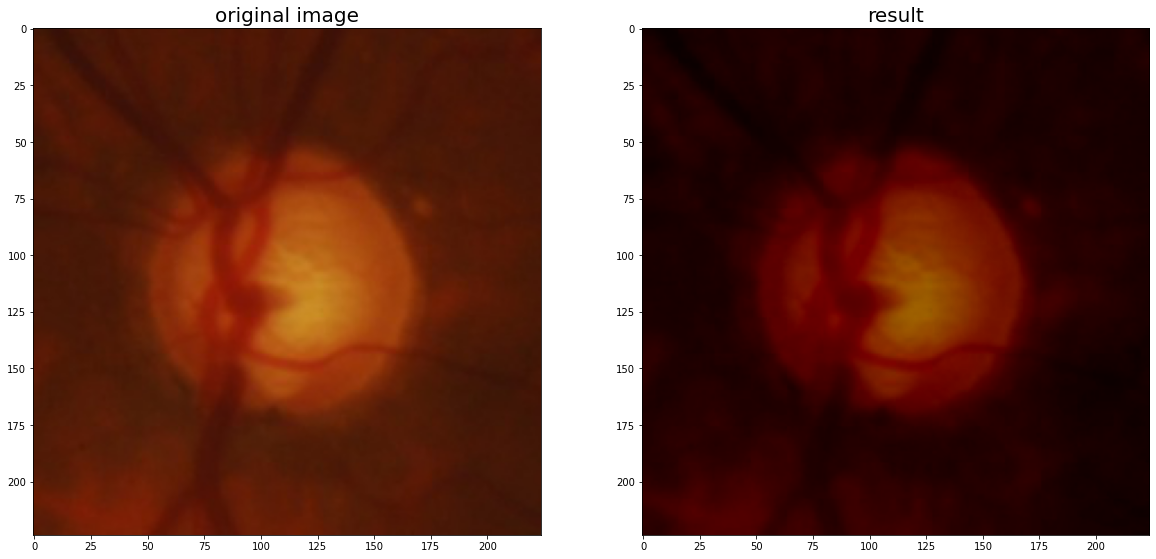

In [25]:
# filter df_all status = abnormal
df_all_abnormal = df_all[df_all['status'] == 'abnormal']
imagen(df_all_abnormal.iloc[0]['full_path'])

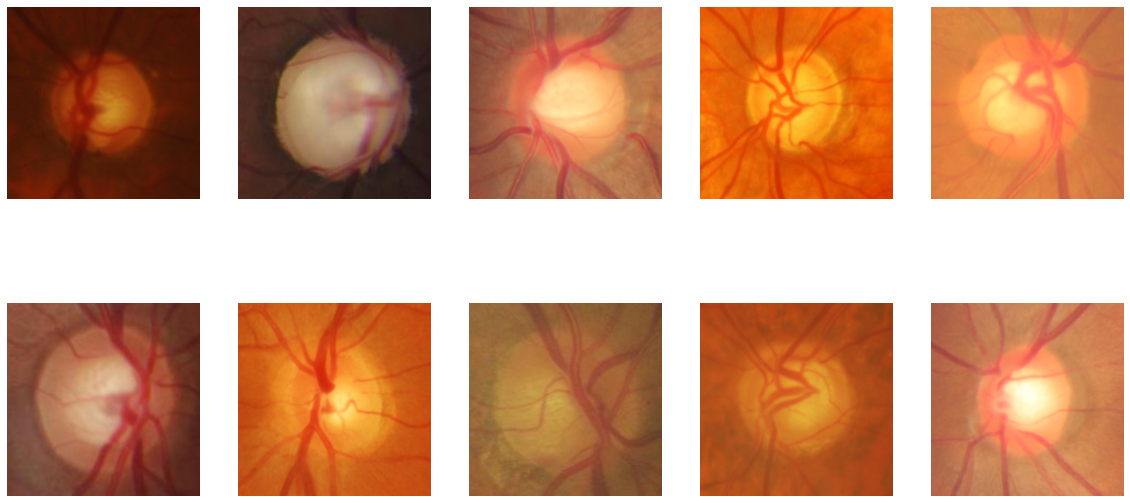

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i in range(10):
    axes[i//5, i%5].imshow(load_image(df_all_abnormal.iloc[i]['full_path']))
    axes[i//5, i%5].axis('off')
plt.show()


# **Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)**

En esta primera parte se hará un entrenamiento únicamente sobre el **fold0**. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando *cross validation* (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

- Las 3 primeras configuraciones se deben implementar en un modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
  - En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (**modelo 1**).
  - En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas (**modelo 2**).
  - En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (**modelo 3**).
- Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (**modelo 4** y **modelo 5**).

En todos los casos, se debe indicar y justificar:

- Elegir la época e hiperparámetros que mejor resultados hayan proporcionado sobre el conjunto de validación durante el entrenamiento.
- Proporcionar y discutir los resultados sobre el conjunto de test.
- Obtener la matriz de confusión, y discutir los resultados teniendo en cuenta los objetivos del problema.


In [27]:
df_all

,image,fold,set,status,full_path
0,WeyEZHlbVV.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/W...
1,GEdLbllOrL.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/G...
2,hxolFIPeVb.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/h...
3,embyZorZmz.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/e...
4,bDPsGesQtp.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/b...
...,...,...,...,...,...
65,ErXihucXJQ.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
66,dPNTYocBLU.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
67,gwnLFsoNDm.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
68,SUGFWkeBAl.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...


In [28]:
# save df_all as csv
df_all.to_csv('data/df_all.csv', index=False)

In [29]:
# Filter data_all by fold
df_fold_0 = df_all[df_all['fold'] == 'Fold0']
df_fold_0.head()

df_fold_0_train = df_fold_0[df_fold_0['set'] == 'train']
df_fold_0_test = df_fold_0[df_fold_0['set'] == 'test']
df_fold_0_valid = df_fold_0[df_fold_0['set'] == 'valid']
y_train = pd.get_dummies(df_fold_0_train['status'])
y_valid = pd.get_dummies(df_fold_0_valid['status'])
y_test = pd.get_dummies(df_fold_0_test['status'])

In [30]:
# convert df_fold_0_train['status'] to one-hot encoding
#df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_valid['status'] = df_fold_0_valid['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_test['status'] = df_fold_0_test['status'].map({'normal': 0, 'abnormal': 1})


In [31]:
# convert df_fold_0_train to a numpy array
X_train = np.array([load_image(x) for x in df_fold_0_train['full_path']])
#y_train = np.array(df_fold_0_train['status'])
y_train = np.array(y_train)

# get max and min values of X_train
X_train_min = X_train.min()
X_train_max = X_train.max()
# normalize X_train
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)


print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

X_train : (1379, 224, 224, 3)
y_train : (1379, 2)


In [32]:
# convert df_fold_0_train to a numpy array
x_valid = np.array([load_image(x) for x in df_fold_0_valid['full_path']])
#y_valid = np.array(df_fold_0_valid['status'])
y_valid = np.array(y_valid)
x_valid_min = x_valid.min()
print("min_valid:", x_valid_min)
x_valid_max = x_valid.max()
print("max_valid:", x_valid_max)
# normalize X_train
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

min_valid: 0
max_valid: 255


In [33]:
# convert df_fold_0_train to a numpy array
x_test = np.array([load_image(x) for x in df_fold_0_test['full_path']])
#y_test = np.array(df_fold_0_test['status'])
y_text = np.array(y_test)
x_test_min = x_test.min()
print("min_valid:", x_test_min)
x_test_max = x_test.max()
print("max_test:", x_test_max)
# normalize X_train
x_test = (x_test - x_test_min) / (x_test_max - x_test_min)

min_valid: 0
max_test: 255


In [34]:
 # Creo una función del loss y F1 Score y que plotee la curva de loss y F1 Score
def plot_training_curves(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_score'], 'r', linewidth=3.0)
    plt.plot(history.history['val_f1_score'], 'b', linewidth=3.0)
    plt.legend(['Training F1-Score', 'Validation F1-Score'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('F1-Score', fontsize=16)
    plt.title('F1 Score Curves', fontsize=16)
    plt.grid(True)
    plt.show()




In [35]:
# Image augmentation para mejorar el rendimiento del modelo realizando rotaciones, zoom, etc..
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#escalado
validation_datagen = ImageDataGenerator(rescale=1./255)

#escalado
test_datagen = ImageDataGenerator(rescale=1./255)


# generador de imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/train/',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de validación
validation_generator = validation_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/valid/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de test
test_generator = test_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/test/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

Found 1379 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


### Modelo 1
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
Se entrena el modelo congelando todas las capas menos las que se han añadido al final 

In [36]:
def model_builder(n_classes, shape, optimizador, lr):
    inputs = layers.Input(shape=shape, name='input')
    # base model EfficientNetB0 with pre-trained weights imagenet
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    # freeze all layers of base model
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)

    # Add Global Average Pooling 2D
    x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
    # Add BatchNormalization
    x = layers.BatchNormalization(name='BatchNormalization')(x)
    # add Dropout with 0.2 probability
    x = layers.Dropout(0.2, name='Dropout')(x)
    # unfreeze last layer of base model
    base_model.layers[-1].trainable = True
    # fully connected layer with softmax activation
    output = layers.Dense(n_classes, activation='softmax', name='output')(x)
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    # compile model
    #model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizador, loss='categorical_crossentropy',
                  metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    # summarize model
    model.summary()
    return model

model_builder(2, (224, 224, 3), 'Adam', 0.0001)



16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1280)             5120      
 rmalization)                                                    
                                                                 
 Dropout (Dropout)           (None, 1280)              0         
                                                              

In [44]:

def model_1_build(n_classes, shape, optimizer, lr):
    #print('Number of classes:', n_classes, '\nShape:', shape, '\nOptimizer:', optimizer, '\nLearning rate:', lr)
    inputs = layers.Input(shape=shape, name='inputs')
    # base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet')

    # Freeze layers
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Add new layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid', name='outputs')(x)

    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # set metrics f1_score
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    

    #model.summary()

    # freeze layers
    for layer in model.layers:
        layer.trainable = False
    # save the model
    model.save('data/models/model_1.h5')

    # save weights
    model.save_weights('data/models/model_1_weights.h5')

    return model


In [40]:
model=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 2)                 2562

In [ ]:

# choose the epoch and hyperparameters for the model over validation set during training
params = {
    'epochs': [50, 80, 100],
    'batch_size': [16, 32],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}


In [ ]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
              for batch_size in params['batch_size']:
                print('Batch_size:', batch_size, '\tEpochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                print("Batch_size:", batch_size, "\tEpochs:", epochs, "\tOptimizer:", optimizer, "\tLearning rate:", lr, "\tLoss:", loss, "\tAccuracy:", accuracy)
                # store the results
                results = results.append({'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
              
                    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.0001
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.0001
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.001
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.001
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.01
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.01
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.1
Batch_size: 32 	Epochs:

In [ ]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
              for batch_size in params['batch_size']:
                #print('Batch_size:', batch_size, '\tEpochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                print("Batch_size:", batch_size, "\tEpochs:", epochs, "\tOptimizer:", optimizer, "\tLearning rate:", lr, "\tLoss:", loss, "\tAccuracy:", accuracy)
                # store the results
                results = results.append({'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
              
                    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001 	Loss: 0.6376324892044067 	Accuracy: 0.6040780544281006
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001 	Loss: 0.6467400193214417 	Accuracy: 0.5960161685943604
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001 	Loss: 0.5548949837684631 	Accuracy: 0.7239781618118286
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001 	Loss: 0.5676046013832092 	Accuracy: 0.6878423690795898
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01 	Loss: 0.5369910001754761 	Accuracy: 0.7253230214118958
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01 	Loss: 0.6005755066871643 	Accuracy: 0.6921002268791199
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1 	Loss: 0.562857985496521 	Accuracy: 0.7083333730697632
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1 	Loss: 1.742424488067627 	Accuracy: 0.4235481023788452
Batch_size: 16 	Epochs: 50 	Op

En este caso el mejor modelo es Adam, con lr de 0.0010, epoch =80 y Batch 32

In [41]:
batch_size = 32
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [48]:
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.001)
# train the model

# creo callbacks de early stopping para para el entrenamiento si no hay mejora en loss 
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


history = model_1.fit(
      train_generator,
      steps_per_epoch= steps_per_epoch,
      epochs= 80,
      validation_data= validation_generator,
      validation_steps= validation_steps,
      callbacks = es1)


Epoch 1/80
43/43 [==============================] - 22s 399ms/step - loss: 0.6726 - f1_score: 0.4896 - val_loss: 0.7296 - val_f1_score: 0.3568
Epoch 2/80
43/43 [==============================] - 17s 384ms/step - loss: 0.6599 - f1_score: 0.5813 - val_loss: 0.6901 - val_f1_score: 0.3568
Epoch 3/80
43/43 [==============================] - 16s 368ms/step - loss: 0.6492 - f1_score: 0.5951 - val_loss: 0.6910 - val_f1_score: 0.5714
Epoch 4/80
43/43 [==============================] - 16s 366ms/step - loss: 0.6368 - f1_score: 0.6148 - val_loss: 0.6932 - val_f1_score: 0.3494
Epoch 5/80
43/43 [==============================] - 16s 365ms/step - loss: 0.6317 - f1_score: 0.6227 - val_loss: 0.6920 - val_f1_score: 0.3900
Epoch 6/80
43/43 [==============================] - 16s 368ms/step - loss: 0.6294 - f1_score: 0.6313 - val_loss: 0.7326 - val_f1_score: 0.3081
Epoch 7/80
43/43 [==============================] - 16s 367ms/step - loss: 0.6179 - f1_score: 0.6664 - val_loss: 0.7397 - val_f1_score: 0.3081

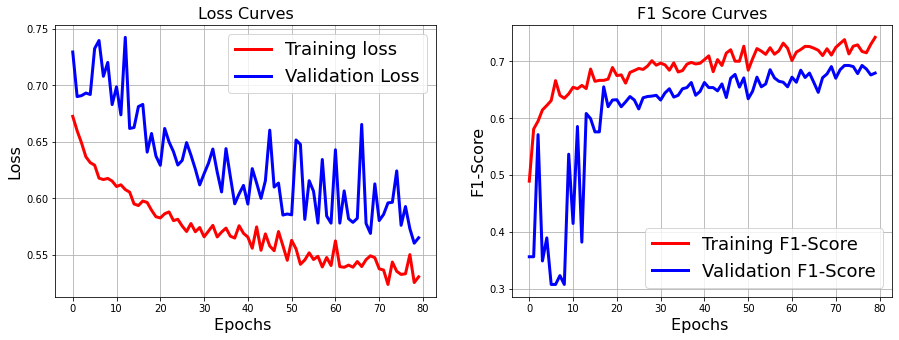

In [49]:
# represento la precisión y la pérdida del modelo
plot_training_curves(history)


In [50]:
# Image augmentation para mejorar el rendimiento del modelo realizando rotaciones, zoom, etc..
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#escalado
validation_datagen = ImageDataGenerator(rescale=1./255)

#escalado
test_datagen = ImageDataGenerator(rescale=1./255)


# generador de imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/train/',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de validación
validation_generator = validation_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/valid/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de test
test_generator = test_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/test/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

Found 1379 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


In [51]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_1.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[66 26]
 [15 67]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.81      0.72      0.76        92
      normal       0.72      0.82      0.77        82

    accuracy                           0.76       174
   macro avg       0.77      0.77      0.76       174
weighted avg       0.77      0.76      0.76       174



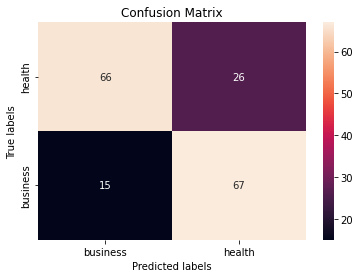

In [53]:
cm = confusion_matrix(test_generator.classes, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

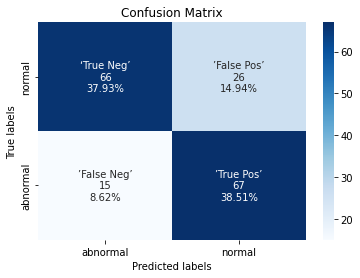

In [56]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

In [ ]:
# Model 1
# Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*
def creador_modelo(n_classes, shape, optimizer, lr):
    prev_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)
    model_1 = models.Sequential()
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    model_1.add(prev_model)
    # sustituir la capa de clasificación por una capa GlobalAveragePooling2D
    model_1.add(layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'))
    # layer of "BatchNormalization"
    model_1.add(layers.BatchNormalization())
    # layer of "Dropout"
    model_1.add(layers.Dropout(0.2))
    # layer of Fully Connected
    model_1.layers[-1].trainable = True
    model_1.add(layers.Dense(n_classes, activation='sigmoid'))
    # compile the model
    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    #model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_1.summary()


    # compile the model
    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss='binary_crossentropy',
                            metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'),
                            run_eagerly=True)
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    # save the model
    #model_1.save('data/models/model_1.h5')

    # save weights
    #model_1.save_weights('data/models/model_1_weights.h5')

    return model_1


In [ ]:

model_1 = creador_modelo(2, (224, 224, 3), 'Adam', 0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 batch_normalization_13 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,057,253
Trainable params: 4,012,670
No

In [ ]:
train = X_train
batch_size = 32
valid = x_valid
steps_per_epoch = train // batch_size
validation_steps = valid // batch_size
epoch = 10
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]


In [ ]:
# train the model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_valid,y_valid),
                        callbacks=callbacks,
                        verbose=1)
                        

Epoch 1/10
44/44 [==============================] - 19s 391ms/step - loss: 0.5906 - f1_score: 0.7388 - val_loss: 0.7311 - val_f1_score: 0.3156 - lr: 1.0000e-04
Epoch 2/10
44/44 [==============================] - 17s 384ms/step - loss: 0.3468 - f1_score: 0.8623 - val_loss: 0.7382 - val_f1_score: 0.3156 - lr: 1.0000e-04
Epoch 3/10
44/44 [==============================] - 18s 413ms/step - loss: 0.2481 - f1_score: 0.9093 - val_loss: 0.6949 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 4/10
44/44 [==============================] - 17s 390ms/step - loss: 0.1964 - f1_score: 0.9273 - val_loss: 0.6908 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 5/10
44/44 [==============================] - 17s 386ms/step - loss: 0.1716 - f1_score: 0.9400 - val_loss: 0.6925 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 6/10
44/44 [==============================] - 17s 384ms/step - loss: 0.1356 - f1_score: 0.9612 - val_loss: 0.6969 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 7/10
44/44 [======================

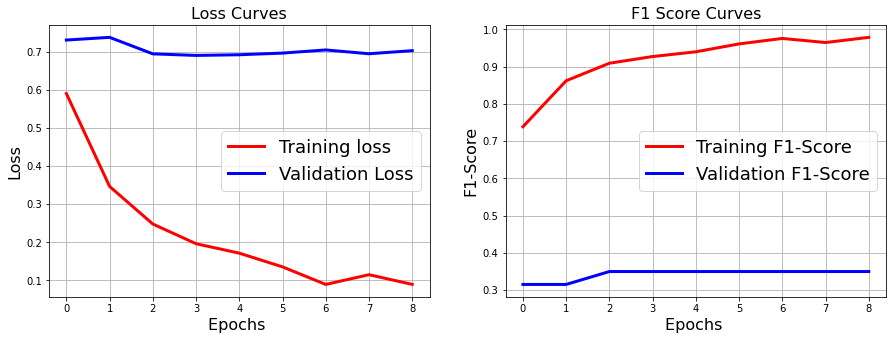

In [ ]:
# represento la precisión y la pérdida del modelo
plot_training_curves(history_1)

In [64]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_1.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[66 26]
 [15 67]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.81      0.72      0.76        92
      normal       0.72      0.82      0.77        82

    accuracy                           0.76       174
   macro avg       0.77      0.77      0.76       174
weighted avg       0.77      0.76      0.76       174



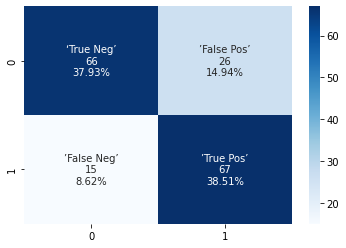

In [65]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 2
modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
 A partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas  

In [57]:
shape = (224, 224, 3)
num_classes = 2

In [58]:
head_model = tf.keras.applications.EfficientNetB0(input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model2 = tf.keras.Model(inputs, outputs)

# cargamos los pesos del modelo 1
model2.load_weights('data/models/model_1_weights.h5',
                    skip_mismatch=False, by_name=True)

# entrenamos las 20 últimas capas
for layer in model2.layers[:20]:
  layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lr = 1e-3
epochs = 80
batch_size = 32
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]

# Compile
# model2.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_9 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 256

In [59]:
# freeze layers
for layer in model2.layers:
  layer.trainable = False

# save model2
model2.save('data/models/model_2.h5')
# save weights of model2
model2.save_weights('data/models/model_2_weights.h5')


In [60]:
batch_size = 32
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size


In [61]:

# Fit
H_model_2 = model2.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)



Epoch 1/80
43/43 [==============================] - 38s 512ms/step - loss: 0.7722 - f1_score: 0.7288 - val_loss: 0.8613 - val_f1_score: 0.5054 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 21s 488ms/step - loss: 0.5094 - f1_score: 0.8149 - val_loss: 0.8865 - val_f1_score: 0.5256 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 20s 467ms/step - loss: 0.4069 - f1_score: 0.8392 - val_loss: 1.0949 - val_f1_score: 0.5703 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 20s 463ms/step - loss: 0.3203 - f1_score: 0.8689 - val_loss: 1.3240 - val_f1_score: 0.5294 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 23s 530ms/step - loss: 0.3257 - f1_score: 0.8723 - val_loss: 1.3328 - val_f1_score: 0.6132 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 20s 468ms/step - loss: 0.3891 - f1_score: 0.8387 - val_loss: 0.8784 - val_f1_score: 0.5785 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 21s 480ms/st

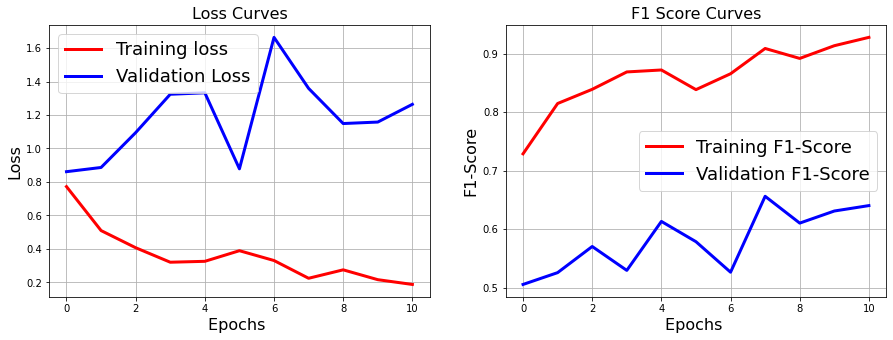

In [62]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_2)

In [68]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model2.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[92  0]
 [81  1]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.53      1.00      0.69        92
      normal       1.00      0.01      0.02        82

    accuracy                           0.53       174
   macro avg       0.77      0.51      0.36       174
weighted avg       0.75      0.53      0.38       174



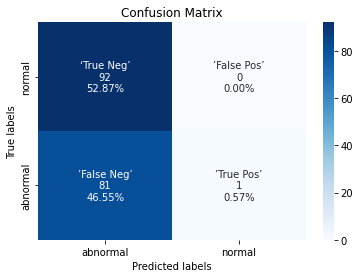

In [69]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 3
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
A partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad 

In [70]:
head_model = tf.keras.applications.EfficientNetB0(
    input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model3 = tf.keras.Model(inputs, outputs)

# save model3
model3.save('data/models/model_3.h5')
# save the weights
model3.save_weights('data/models/model_3_weights.h5')

# cargamos los pesos del modelo 2
model3.load_weights('data/models/model_2_weights.h5', skip_mismatch=False, by_name=True)
# descongelamos todas las capas
model3.trainable = True

# Compile
model3.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

h_model_3 = model3.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)


Epoch 1/80
43/43 [==============================] - 32s 539ms/step - loss: 1.1443 - f1_score: 0.5956 - val_loss: 0.8941 - val_f1_score: 0.4632 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 24s 558ms/step - loss: 0.6963 - f1_score: 0.6774 - val_loss: 0.9072 - val_f1_score: 0.3900 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 25s 552ms/step - loss: 0.5854 - f1_score: 0.7237 - val_loss: 0.7522 - val_f1_score: 0.5308 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 20s 468ms/step - loss: 0.5461 - f1_score: 0.7598 - val_loss: 0.8872 - val_f1_score: 0.4849 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 21s 473ms/step - loss: 0.6235 - f1_score: 0.7640 - val_loss: 0.7534 - val_f1_score: 0.5461 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 21s 482ms/step - loss: 0.7153 - f1_score: 0.7297 - val_loss: 0.9949 - val_f1_score: 0.5103 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 29s 654ms/st

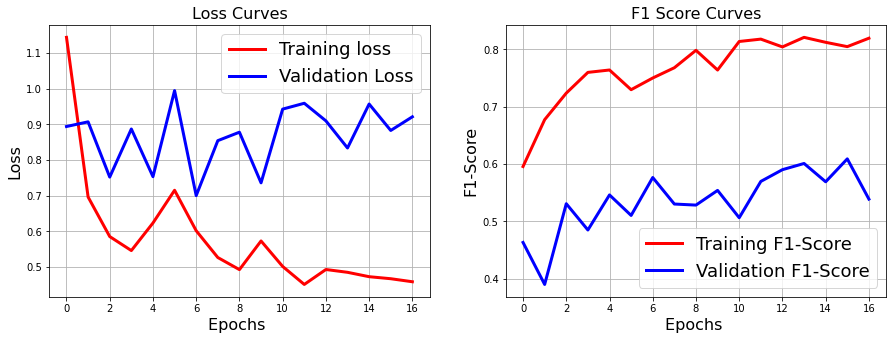

In [71]:
# represento la precisión y la pérdida del modelo
plot_training_curves(h_model_3)

In [72]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model3.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[46 46]
 [34 48]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.57      0.50      0.53        92
      normal       0.51      0.59      0.55        82

    accuracy                           0.54       174
   macro avg       0.54      0.54      0.54       174
weighted avg       0.54      0.54      0.54       174



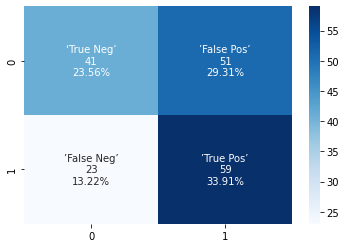

In [ ]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 4

Una capa convulucional

In [ ]:
# CNN model of one convolutional layer
def build_model_4(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # convolutional layer
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout1')(x)
    
    # flatten
    x = tf.keras.layers.Flatten()(x)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
        metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

    # save the model
    model.save('data/models/model_4.h5')
    # save the weights
    model.save_weights('data/models/model_4_weights.h5')

    return model

model_4 = build_model_4(num_classes, shape)
# Fit
H_model_4 = model_4.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)


Epoch 1/80
43/43 [==============================] - 16s 363ms/step - loss: 18.6098 - f1_score: 0.6971 - val_loss: 2.0067 - val_f1_score: 0.3825 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 15s 354ms/step - loss: 1.2727 - f1_score: 0.7370 - val_loss: 0.6904 - val_f1_score: 0.5789 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 15s 348ms/step - loss: 0.6273 - f1_score: 0.7523 - val_loss: 0.6921 - val_f1_score: 0.3683 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 15s 350ms/step - loss: 0.4994 - f1_score: 0.7468 - val_loss: 0.7071 - val_f1_score: 0.3081 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 15s 354ms/step - loss: 0.5229 - f1_score: 0.7262 - val_loss: 0.6754 - val_f1_score: 0.3964 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 15s 357ms/step - loss: 0.4332 - f1_score: 0.7898 - val_loss: 0.6119 - val_f1_score: 0.6869 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 15s 349ms/s

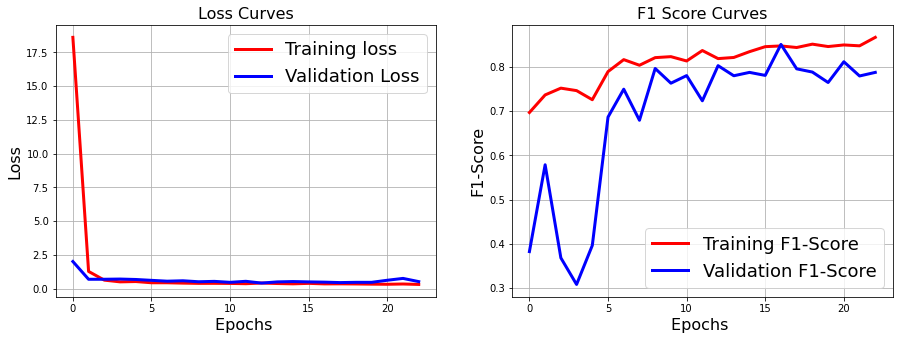

In [ ]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_4)

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_4.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[84  8]
 [11 71]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.88      0.91      0.90        92
      normal       0.90      0.87      0.88        82

    accuracy                           0.89       174
   macro avg       0.89      0.89      0.89       174
weighted avg       0.89      0.89      0.89       174



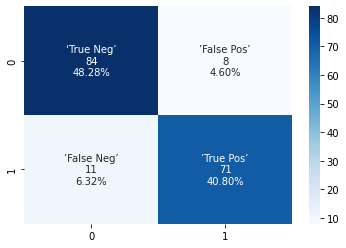

In [ ]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
plt.show()

### Modelo 5

Un modelo sencillo

In [ ]:
# get a simply model
def build_model_5(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # flatten
    x = tf.keras.layers.Flatten()(inputs)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))
    # get the model summary
    model.summary()

    # save the model
    model.save('data/models/model_5.h5')
    # save the weights
    model.save_weights('data/models/model_5_weights.h5')

    return model

model_5 = build_model_5(num_classes, shape)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense1 (Dense)              (None, 128)               19267712  
                                                                 
 dropout2 (Dropout)          (None, 128)               0         
                                                                 
 pred (Dense)                (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit
H_model_5 = model_5.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)

Epoch 1/80
43/43 [==============================] - 15s 338ms/step - loss: 10.1490 - f1_score: 0.6351 - val_loss: 0.8149 - val_f1_score: 0.4741 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 14s 332ms/step - loss: 0.6845 - f1_score: 0.4938 - val_loss: 0.6924 - val_f1_score: 0.3005 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 14s 328ms/step - loss: 0.6569 - f1_score: 0.3778 - val_loss: 0.6942 - val_f1_score: 0.6699 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 14s 330ms/step - loss: 0.6204 - f1_score: 0.6744 - val_loss: 0.6580 - val_f1_score: 0.6624 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 15s 338ms/step - loss: 0.6262 - f1_score: 0.6406 - val_loss: 0.6900 - val_f1_score: 0.3568 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 14s 331ms/step - loss: 0.6963 - f1_score: 0.3110 - val_loss: 0.6913 - val_f1_score: 0.3568 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 14s 331ms/s

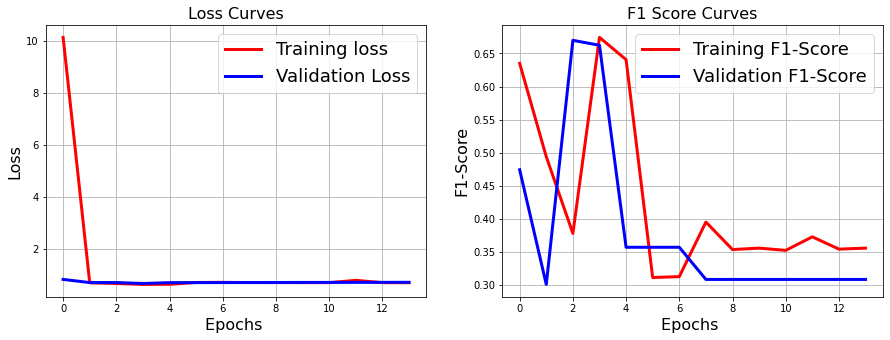

In [ ]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_5)

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_5.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[56 36]
 [ 4 78]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.93      0.61      0.74        92
      normal       0.68      0.95      0.80        82

    accuracy                           0.77       174
   macro avg       0.81      0.78      0.77       174
weighted avg       0.82      0.77      0.76       174



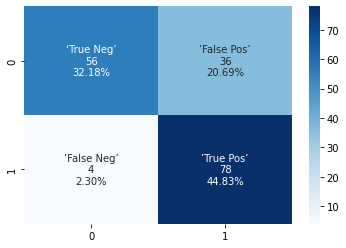

In [ ]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
plt.show()


# **Sección 3. Validación cruzada y discusión (3 puntos)**

El objetivo de la técnica de *cross validation* es seleccionar qué modelo es más adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (**fold0**) y se han estudiado 5 modelos distintos.

En este caso, se debe:

- Aplicar una técnica de *cross validation* sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de **fold0** a **fold9**), por lo que se debe entrenar el modelo escogido sobre los datos de *train* de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.
- Obtener el valor de **F1 score** de cada partición sobre el conjunto de test. De esta forma, se obtendrán 10 valores **F1 score** de test distintos.
- Calcular el valor medio y la desviación estándar.




Fold0
Epoch 1/80
44/44 [==============================] - 18s 395ms/step - loss: 0.4980 - f1_score: 0.7583 - val_loss: 0.5357 - val_f1_score: 0.7210
Epoch 2/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4960 - f1_score: 0.7482 - val_loss: 0.5224 - val_f1_score: 0.7574
Epoch 3/80
44/44 [==============================] - 17s 381ms/step - loss: 0.5044 - f1_score: 0.7434 - val_loss: 0.5275 - val_f1_score: 0.7314
Epoch 4/80
44/44 [==============================] - 16s 371ms/step - loss: 0.4932 - f1_score: 0.7558 - val_loss: 0.5255 - val_f1_score: 0.7326
Epoch 5/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4947 - f1_score: 0.7571 - val_loss: 0.5240 - val_f1_score: 0.7436
Epoch 6/80
44/44 [==============================] - 16s 371ms/step - loss: 0.5215 - f1_score: 0.7306 - val_loss: 0.5448 - val_f1_score: 0.7215
Epoch 7/80
44/44 [==============================] - 16s 367ms/step - loss: 0.5020 - f1_score: 0.7368 - val_loss: 0.5243 - val_f1_score: 

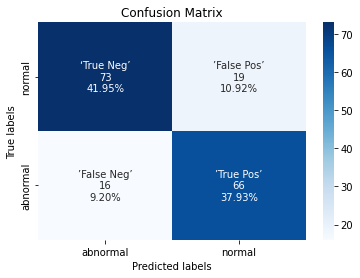

Fold1
Epoch 1/80
44/44 [==============================] - 16s 371ms/step - loss: 0.4863 - f1_score: 0.7556 - val_loss: 0.5321 - val_f1_score: 0.7285
Epoch 2/80
44/44 [==============================] - 17s 390ms/step - loss: 0.5027 - f1_score: 0.7484 - val_loss: 0.5324 - val_f1_score: 0.7465
Epoch 3/80
44/44 [==============================] - 16s 366ms/step - loss: 0.5009 - f1_score: 0.7426 - val_loss: 0.5295 - val_f1_score: 0.7253
Epoch 4/80
44/44 [==============================] - 16s 365ms/step - loss: 0.5031 - f1_score: 0.7441 - val_loss: 0.5278 - val_f1_score: 0.7420
Epoch 5/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4980 - f1_score: 0.7460 - val_loss: 0.5408 - val_f1_score: 0.7056
Epoch 6/80
44/44 [==============================] - 17s 384ms/step - loss: 0.4850 - f1_score: 0.7604 - val_loss: 0.5238 - val_f1_score: 0.7358
Epoch 7/80
44/44 [==============================] - 16s 372ms/step - loss: 0.4900 - f1_score: 0.7566 - val_loss: 0.5239 - val_f1_score: 

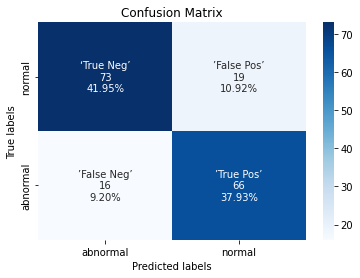

Fold2
Epoch 1/80
44/44 [==============================] - 16s 372ms/step - loss: 0.4998 - f1_score: 0.7506 - val_loss: 0.5272 - val_f1_score: 0.7319
Epoch 2/80
44/44 [==============================] - 16s 369ms/step - loss: 0.5005 - f1_score: 0.7444 - val_loss: 0.5320 - val_f1_score: 0.7401
Epoch 3/80
44/44 [==============================] - 16s 370ms/step - loss: 0.4991 - f1_score: 0.7542 - val_loss: 0.5254 - val_f1_score: 0.7305
Epoch 4/80
44/44 [==============================] - 16s 371ms/step - loss: 0.4939 - f1_score: 0.7495 - val_loss: 0.5578 - val_f1_score: 0.7068
Epoch 5/80
44/44 [==============================] - 16s 372ms/step - loss: 0.5084 - f1_score: 0.7340 - val_loss: 0.5233 - val_f1_score: 0.7471
Epoch 6/80
44/44 [==============================] - 16s 369ms/step - loss: 0.4987 - f1_score: 0.7572 - val_loss: 0.5287 - val_f1_score: 0.7314
Epoch 7/80
44/44 [==============================] - 16s 376ms/step - loss: 0.5117 - f1_score: 0.7393 - val_loss: 0.5240 - val_f1_score: 

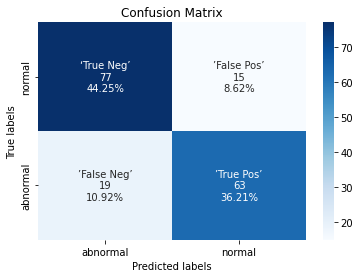

Fold3
Epoch 1/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4901 - f1_score: 0.7528 - val_loss: 0.5478 - val_f1_score: 0.7054
Epoch 2/80
44/44 [==============================] - 16s 365ms/step - loss: 0.4944 - f1_score: 0.7529 - val_loss: 0.5284 - val_f1_score: 0.7326
Epoch 3/80
44/44 [==============================] - 16s 364ms/step - loss: 0.4903 - f1_score: 0.7609 - val_loss: 0.5250 - val_f1_score: 0.7410
Epoch 4/80
44/44 [==============================] - 16s 364ms/step - loss: 0.4913 - f1_score: 0.7403 - val_loss: 0.5330 - val_f1_score: 0.7285
Epoch 5/80
44/44 [==============================] - 16s 363ms/step - loss: 0.5007 - f1_score: 0.7534 - val_loss: 0.5224 - val_f1_score: 0.7367
Epoch 6/80
44/44 [==============================] - 16s 366ms/step - loss: 0.5351 - f1_score: 0.7358 - val_loss: 0.5584 - val_f1_score: 0.7265
Epoch 7/80
44/44 [==============================] - 16s 365ms/step - loss: 0.4887 - f1_score: 0.7646 - val_loss: 0.5312 - val_f1_score: 

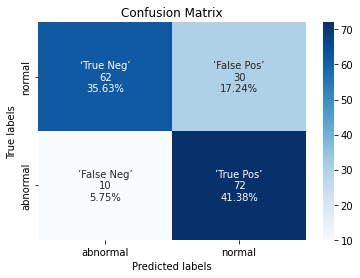

Fold4
Epoch 1/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4915 - f1_score: 0.7538 - val_loss: 0.5291 - val_f1_score: 0.7374
Epoch 2/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4925 - f1_score: 0.7531 - val_loss: 0.5236 - val_f1_score: 0.7324
Epoch 3/80
44/44 [==============================] - 16s 366ms/step - loss: 0.5106 - f1_score: 0.7371 - val_loss: 0.5302 - val_f1_score: 0.7300
Epoch 4/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4939 - f1_score: 0.7569 - val_loss: 0.5255 - val_f1_score: 0.7367
Epoch 5/80
44/44 [==============================] - 16s 370ms/step - loss: 0.4984 - f1_score: 0.7509 - val_loss: 0.5220 - val_f1_score: 0.7226
Epoch 6/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4915 - f1_score: 0.7472 - val_loss: 0.5349 - val_f1_score: 0.7390
Epoch 7/80
44/44 [==============================] - 16s 365ms/step - loss: 0.4910 - f1_score: 0.7535 - val_loss: 0.5431 - val_f1_score: 

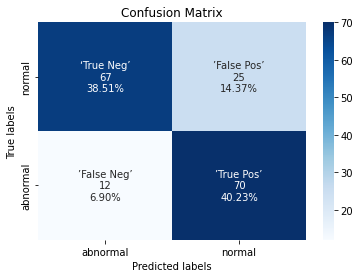

Fold5
Epoch 1/80
44/44 [==============================] - 16s 371ms/step - loss: 0.4867 - f1_score: 0.7538 - val_loss: 0.5299 - val_f1_score: 0.7361
Epoch 2/80
44/44 [==============================] - 19s 437ms/step - loss: 0.4852 - f1_score: 0.7642 - val_loss: 0.5283 - val_f1_score: 0.7529
Epoch 3/80
44/44 [==============================] - 23s 506ms/step - loss: 0.4964 - f1_score: 0.7538 - val_loss: 0.5246 - val_f1_score: 0.7399
Epoch 4/80
44/44 [==============================] - 21s 471ms/step - loss: 0.4937 - f1_score: 0.7544 - val_loss: 0.5213 - val_f1_score: 0.7367
Epoch 5/80
44/44 [==============================] - 24s 559ms/step - loss: 0.4986 - f1_score: 0.7546 - val_loss: 0.5285 - val_f1_score: 0.7462
Epoch 6/80
44/44 [==============================] - 20s 460ms/step - loss: 0.4973 - f1_score: 0.7435 - val_loss: 0.5290 - val_f1_score: 0.7496
Epoch 7/80
44/44 [==============================] - 18s 408ms/step - loss: 0.4895 - f1_score: 0.7651 - val_loss: 0.5234 - val_f1_score: 

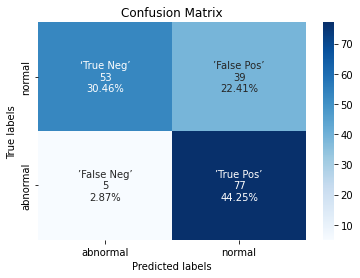

Fold6
Epoch 1/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4869 - f1_score: 0.7505 - val_loss: 0.5227 - val_f1_score: 0.7374
Epoch 2/80
44/44 [==============================] - 16s 366ms/step - loss: 0.5185 - f1_score: 0.7430 - val_loss: 0.5622 - val_f1_score: 0.7063
Epoch 3/80
44/44 [==============================] - 16s 376ms/step - loss: 0.4841 - f1_score: 0.7700 - val_loss: 0.5270 - val_f1_score: 0.7348
Epoch 4/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4861 - f1_score: 0.7630 - val_loss: 0.5320 - val_f1_score: 0.7396
Epoch 5/80
44/44 [==============================] - 17s 381ms/step - loss: 0.4855 - f1_score: 0.7503 - val_loss: 0.5296 - val_f1_score: 0.7462
Epoch 6/80
44/44 [==============================] - 18s 411ms/step - loss: 0.4926 - f1_score: 0.7487 - val_loss: 0.5239 - val_f1_score: 0.7297
Epoch 6: early stopping
              precision    recall  f1-score   support

    abnormal       0.86      0.78      0.82        92
   

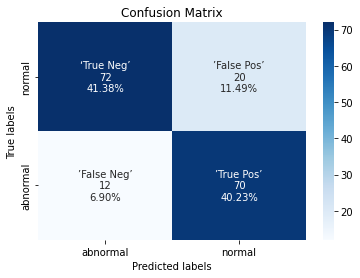

Fold7
Epoch 1/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4915 - f1_score: 0.7501 - val_loss: 0.5271 - val_f1_score: 0.7235
Epoch 2/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4876 - f1_score: 0.7581 - val_loss: 0.5329 - val_f1_score: 0.7300
Epoch 3/80
44/44 [==============================] - 16s 368ms/step - loss: 0.4871 - f1_score: 0.7554 - val_loss: 0.5266 - val_f1_score: 0.7392
Epoch 4/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4897 - f1_score: 0.7649 - val_loss: 0.5344 - val_f1_score: 0.7399
Epoch 5/80
44/44 [==============================] - 17s 376ms/step - loss: 0.4808 - f1_score: 0.7602 - val_loss: 0.5365 - val_f1_score: 0.7225
Epoch 6/80
44/44 [==============================] - 16s 364ms/step - loss: 0.5063 - f1_score: 0.7473 - val_loss: 0.5482 - val_f1_score: 0.7141
Epoch 7/80
44/44 [==============================] - 16s 366ms/step - loss: 0.4884 - f1_score: 0.7585 - val_loss: 0.5270 - val_f1_score: 

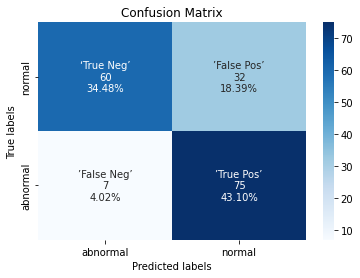

Fold8
Epoch 1/80
44/44 [==============================] - 16s 366ms/step - loss: 0.4978 - f1_score: 0.7479 - val_loss: 0.5455 - val_f1_score: 0.7141
Epoch 2/80
44/44 [==============================] - 16s 365ms/step - loss: 0.4936 - f1_score: 0.7570 - val_loss: 0.5300 - val_f1_score: 0.7496
Epoch 3/80
44/44 [==============================] - 16s 363ms/step - loss: 0.4798 - f1_score: 0.7684 - val_loss: 0.5274 - val_f1_score: 0.7277
Epoch 4/80
44/44 [==============================] - 16s 366ms/step - loss: 0.4867 - f1_score: 0.7535 - val_loss: 0.5259 - val_f1_score: 0.7481
Epoch 5/80
44/44 [==============================] - 16s 364ms/step - loss: 0.4972 - f1_score: 0.7501 - val_loss: 0.5339 - val_f1_score: 0.7285
Epoch 6/80
44/44 [==============================] - 16s 365ms/step - loss: 0.4895 - f1_score: 0.7506 - val_loss: 0.5973 - val_f1_score: 0.6749
Epoch 7/80
44/44 [==============================] - 16s 363ms/step - loss: 0.5124 - f1_score: 0.7369 - val_loss: 0.5263 - val_f1_score: 

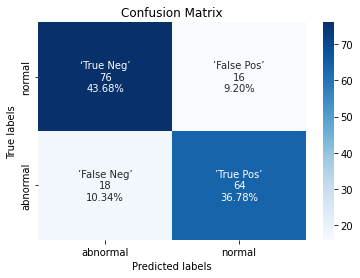

Fold9
Epoch 1/80
44/44 [==============================] - 16s 366ms/step - loss: 0.4861 - f1_score: 0.7647 - val_loss: 0.5268 - val_f1_score: 0.7522
Epoch 2/80
44/44 [==============================] - 17s 383ms/step - loss: 0.4995 - f1_score: 0.7379 - val_loss: 0.5238 - val_f1_score: 0.7367
Epoch 3/80
44/44 [==============================] - 16s 363ms/step - loss: 0.4820 - f1_score: 0.7627 - val_loss: 0.5235 - val_f1_score: 0.7410
Epoch 4/80
44/44 [==============================] - 16s 363ms/step - loss: 0.4862 - f1_score: 0.7577 - val_loss: 0.5453 - val_f1_score: 0.7294
Epoch 5/80
44/44 [==============================] - 16s 364ms/step - loss: 0.4849 - f1_score: 0.7511 - val_loss: 0.5432 - val_f1_score: 0.7207
Epoch 6/80
44/44 [==============================] - 16s 363ms/step - loss: 0.5004 - f1_score: 0.7593 - val_loss: 0.5264 - val_f1_score: 0.7381
Epoch 7/80
44/44 [==============================] - 16s 366ms/step - loss: 0.4754 - f1_score: 0.7702 - val_loss: 0.5309 - val_f1_score: 

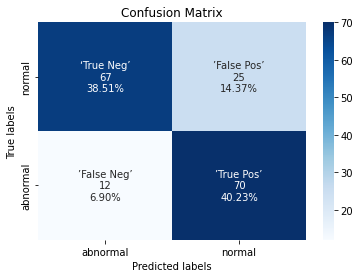

In [81]:
f1_sco = []

for i in range(10):
  fold = 'Fold'+str(i)

  print(fold)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
  history_callback = model_1.fit(train_generator, validation_data= validation_generator, epochs=80, verbose=1, batch_size = 32, callbacks = [es])

  filenames = test_generator.filenames
  nb_samples = len(filenames)

  # confusión matrix
  Y_pred = model_1.predict(test_generator, steps = nb_samples)
  y_pred = np.argmax(Y_pred, axis=1)

  target_names = list(train_generator.class_indices.keys())
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))
  res = classification_report(test_generator.classes, y_pred, target_names=target_names, output_dict = True)

  f1_sco.append(res['normal']['f1-score'])
  f1_sco.append(res['abnormal']['f1-score'])

  cf_matrix = confusion_matrix(test_generator.classes, y_pred)
  group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax= plt.subplot()
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
  plt.show()

  



In [82]:
print(f1_sco)

[0.7904191616766466, 0.8066298342541436, 0.7904191616766466, 0.8066298342541436, 0.7875, 0.8191489361702128, 0.782608695652174, 0.7560975609756099, 0.7909604519774011, 0.7836257309941521, 0.7777777777777779, 0.7066666666666667, 0.8139534883720929, 0.8181818181818182, 0.7936507936507937, 0.7547169811320754, 0.7901234567901235, 0.8172043010752688, 0.7909604519774011, 0.7836257309941521]


In [83]:
import numpy as np
print(f'La media del F1-Score de todos los conjuntos es: {np.mean(f1_sco)}')

La media del F1-Score de todos los conjuntos es: 0.7880450417124651


In [84]:
print(f'La desviación estándard de los conjuntos es: {np.std(f1_sco)}')

La desviación estándard de los conjuntos es: 0.025573582368226284



Finalmente, fíjate en las matrices de *cross validation* que se han obtenido en la sección 2. El Glaucoma es una patología muy grave, por lo que es importante reducir los **falsos negativos (FN)** del modelo. ¿Qué estrategia seguirías para conseguir este propósito y qué penalizaciones podría tener esta decisión?

Para incrementar el rendimiento de nuestro modelo y por tanto reducir el número de falsos negativos podíamos tener en cuenta las siguientes opciones.


*   En nuestro caso tenemos unas 17 mil imágenes, para obtener mejores resultados podíamos aumentar el número de imágenes del conjunto de entrenamiento
*   Reducir aún más el learning rate y probar con parámetros más pequeños

Como penalizaciones, podemos hablar del incremento temporal y computacional al incrementar tanto el learning rate como el número de imágenes a procesar.





# **Sección 4. Análisis crítico (1,5 puntos)**

Contesta, de forma razonada y justificada, a las siguientes preguntas:

  a) Para la realización de la práctica se han entregado las *folds* preparadas para el entrenamiento.

  i) Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

  ii) Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

  b) Realizar un análisis crítico de los resultados obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.



1.   La estrategia de diseño me parece la adecuada, 
cargar la totalidad de imágenes en memoria requeriría grandes recursos y tener las imágenes separadas en folds parece la óptima. A su vez, el uso de la función flow_from_directory carga un tren de imágenes para evitar colapsar la memoria. Como hemos visto durante el ejercicio, la distribución de imágenes en los distintos folds es casi la misma, tenemos una cantidad igual o similar de imágenes en cada fold de validación, test y entrenamiento.
2.   Como conclusiones podemos decir:

  *   El uso de modelos preentrenados como efficientnet nos ayuda a obtener buenos resultados evitándonos realizar gran parte del entrenamiento.
  *   La aplicación de transfer learning también ha contribuido con éxito a la mejora del modelo
La aplicación de transfer learning también ha contribuido con éxito a la mejora del modelo
  *   La búsqueda del mejor modelo y de los mejores hiperparámetros requiere de grandes tiempos de ejecución y una gran cantidad pruebas.
  *   La clave en este tipo de estudios, además de obtener un valor máximo de precisión de los resultados es reducir al máximo los falsos negativos, ya que estaríamos diagnosticando de forma incorrecta a un paciente con un problema.












8. Entrega

El entregable será un archivo comprimido en formato ZIP con los siguientes documentos:

- **Informe en formato PDF** de entre 8 y 10 páginas de longitud, aproximadamente. No debe contener código (salvo mencionar alguna librería que sea importante indicar, o similar)
- **Código fuente** completo de la práctica. El código usado para todas las etapas de la práctica debe estar correctamente comentado para facilitar su comprensión. Podéis utilizar archivos Python nativos (.py) o basados en Jupyter Notebook (en este caso se debe entregar la versión .ipynb, y la exportación en formato HTML).

Para el **informe** se puede usar la siguiente guía:

- Tamaño de letra 11 o 12
- Fuente: Arial o similar
- Interlineado sencillo
- Las capturas de pantalla (por ejemplo, las gráficas de rendimiento) o los fragmentos de código (si se consideran relevantes) deben estar pensados para ilustrar y no para ser protagonistas.
- Se valora el informe como conjunto y no una sucesión de resultados.
